# CSCI316 Group Assignment 1
# Task 1
# Group: G18

In [1]:
pip install pandas numpy matplotlib seaborn scikit-learn jupyter


Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

sns.set_theme()
pd.set_option("display.max_columns", None)


In [3]:
CSV_PATH = "apartments_for_rent_classified_10K.csv"  

df = pd.read_csv(CSV_PATH, sep=None, engine="python", encoding="cp1252")
df.columns = (df.columns.str.strip()
                        .str.lower()
                        .str.replace(r"\s+", "_", regex=True))
df.drop(columns=["price_display"], errors="ignore", inplace=True)

def _extract_price(series):
    if series is None: 
        return pd.Series([np.nan]*len(df))
    return (series.astype(str)
             .str.replace(",", "", regex=False)
             .str.extract(r"(\d{3,6})")[0]
             .astype("float64"))

if "price" not in df.columns:
    cand = None
    for col in ["title","body"]:
        if col in df.columns:
            tmp = _extract_price(df[col])
            if tmp.notna().sum() > 0:
                cand = tmp; break
    if cand is None:
        raise ValueError("No 'price' column and could not extract it from the dataset.")
    df["price"] = cand

df = df[pd.to_numeric(df["price"], errors="coerce").notna()].copy()
df["price"] = df["price"].astype(float)
df = df[(df["price"]>=100) & (df["price"]<=20000)].copy()
print(df.shape); df[["price"]].describe()


(9998, 21)


,price
count,9998.000000
mean,1478.823265
std,918.379816
min,200.000000
25%,949.000000
50%,1270.000000
75%,1695.000000
max,19500.000000


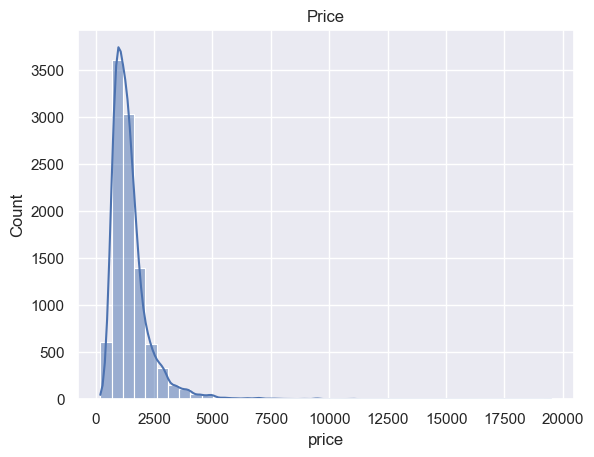

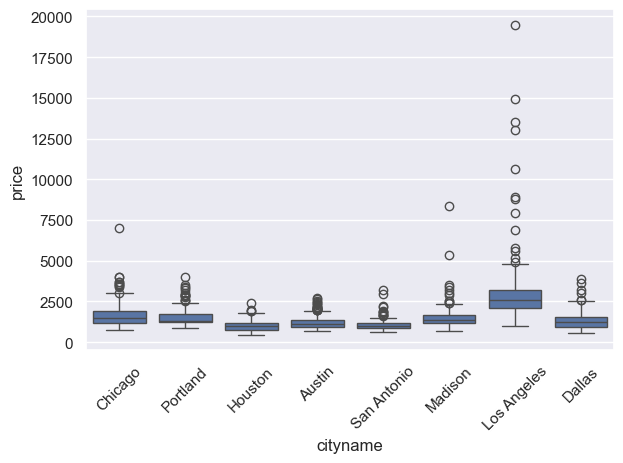

In [4]:
sns.histplot(df["price"], bins=40, kde=True); plt.title("Price"); plt.show()
if "cityname" in df.columns:
    top = df["cityname"].value_counts().head(8).index
    sns.boxplot(x="cityname", y="price", data=df[df["cityname"].isin(top)])
    plt.xticks(rotation=45); plt.tight_layout(); plt.show()


In [5]:
class AddCustomFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, add_features=True): self.add_features = add_features
    def fit(self, X, y=None): return self
    def transform(self, X):
        X = X.copy()
        if not self.add_features: 
            return X
        if {"bedrooms","bathrooms"}.issubset(X.columns):
            X["bed_bath_ratio"] = X["bedrooms"] / (X["bathrooms"].replace(0, np.nan) + 1e-6)
        if "amenities" in X.columns:
            X["amenity_count"] = X["amenities"].fillna("").astype(str).str.count(",") + (X["amenities"].notna()).astype(int)
        if "title" in X.columns: X["title_len"] = X["title"].fillna("").astype(str).str.len()
        if "body"  in X.columns: X["body_len"]  = X["body"].fillna("").astype(str).str.len()
        if "square_feet" in X.columns:
            X["log_square_feet"] = np.log1p(pd.to_numeric(X["square_feet"], errors="coerce"))
        return X

class DynamicPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self): self.preprocessor_ = None
    def fit(self, X, y=None):
        num = X.select_dtypes(include=[np.number]).columns.tolist()
        cat = [c for c in X.columns if c not in num]
        num_tf = Pipeline([("imputer", SimpleImputer(strategy="median")),
                           ("scaler", StandardScaler())])
        cat_tf = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                           ("onehot", OneHotEncoder(handle_unknown="ignore"))])
        self.preprocessor_ = ColumnTransformer([("num", num_tf, num), ("cat", cat_tf, cat)])
        self.preprocessor_.fit(X, y)
        return self
    def transform(self, X):
        return self.preprocessor_.transform(X)

In [6]:
drop_cols = ["id","source","price_display"]
use_cols = [c for c in df.columns if c not in drop_cols]
X = df[use_cols].copy()
y = df["price"].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [7]:
def make_pipe(model):
    return Pipeline([
        ("features", AddCustomFeatures()),  # tuned via features__add_features
        ("prep", DynamicPreprocessor()),
        ("model", model)
    ])

pipes = {
    "LinearRegression": make_pipe(LinearRegression()),
    "RandomForest":     make_pipe(RandomForestRegressor(random_state=42, n_jobs=-1)),
    "GradientBoosting": make_pipe(GradientBoostingRegressor(random_state=42)),
}


## Random Forest

In [8]:
search_space_rf = {
    "features__add_features": [True, False],
    "model__n_estimators": [150, 250, 350],
    "model__max_depth": [None, 10, 20],
    "model__min_samples_leaf": [1, 2, 5],
    "model__min_samples_split": [2, 5, 10],
    "model__max_features": ["sqrt", "log2", 0.5],
}

tuned = {}

rs = RandomizedSearchCV(
    pipes["RandomForest"],
    param_distributions=search_space_rf,
    n_iter=15,      #number of random combos to try
    cv=3,
    n_jobs=-1,
    scoring="neg_root_mean_squared_error",
    random_state=42,
    verbose=1
)

rs.fit(X_train, y_train)
tuned["RandomForest"] = rs

print(
    "RandomForest best params:",
    rs.best_params_,
    "CV best RMSE:",
    -rs.best_score_
)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
RandomForest best params: {'model__n_estimators': 150, 'model__min_samples_split': 2, 'model__min_samples_leaf': 2, 'model__max_features': 0.5, 'model__max_depth': 20, 'features__add_features': True} CV best RMSE: 151.9079047364107


,MAE,RMSE,R2
RandomForest,13.14184,92.685974,0.989517


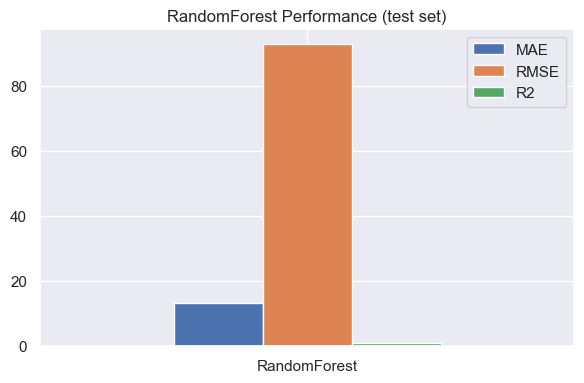

In [9]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#only evaluate RandomForest
results = {}

rf_rs = tuned["RandomForest"]      #get the RandomForest search result
best_rf = rf_rs.best_estimator_    #best tuned pipeline
pred = best_rf.predict(X_test)

mse  = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)                #compute RMSE manually

results["RandomForest"] = {
    "MAE":  mean_absolute_error(y_test, pred),
    "RMSE": rmse,
    "R2":   r2_score(y_test, pred)
}

results_df = pd.DataFrame(results).T
display(results_df)

#plot only RandomForest scores
ax = results_df[["MAE", "RMSE", "R2"]].plot(kind="bar", figsize=(6,4))
plt.title("RandomForest Performance (test set)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


## Linear Regression Model

In [10]:
pipe_lr = pipes["LinearRegression"]

#taking features from AddCustomFeatures class
pipe_lr.set_params(features__add_features=True)

pipe_lr.fit(X_train, y_train)

,steps,"[('features', ...), ('prep', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,add_features,True
,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


Linear Regression (Pipeline) Test Performance
MAE : 0.36
RMSE: 1.00
R²  : 1.0000


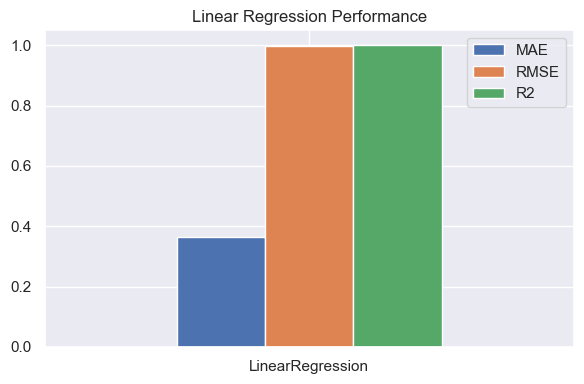

In [11]:
from sklearn.model_selection import cross_val_score

#evaluation on test
y_pred = pipe_lr.predict(X_test)
mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)

print("Linear Regression (Pipeline) Test Performance")
print(f"MAE : {mae:,.2f}")
print(f"RMSE: {rmse:,.2f}")
print(f"R²  : {r2:,.4f}")

#put results in a DataFrame for nice display
results = pd.DataFrame({
    'MAE': [mae],
    'RMSE': [rmse],
    'R2': [r2]
}, index=['LinearRegression'])

import matplotlib.pyplot as plt
results.plot(kind='bar', figsize=(6,4))
plt.title('Linear Regression Performance')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

#### Creating a Feature Coefficient
Tells us how much each feature influences the pricing. The bigger the absolute value, the larger the influence the feature has on the pricing.

Negative coefficient: higher feature value pushes predicted price down

Postivie coefficient: higher feature value pushes predicted price up

In [12]:
#access the fitted ColumnTransformer that is in the DynamicPreprocessor class
ct = pipe_lr.named_steps["prep"].preprocessor_

#taking orig cols used by each transformer
num_cols = list(ct.transformers_[0][2])  #from ("num", num_tf, num_cols)
cat_cols = list(ct.transformers_[1][2])  #from ("cat", cat_tf, cat_cols)

#OHE feature names
ohe = ct.named_transformers_["cat"].named_steps["onehot"]
cat_feature_names = ohe.get_feature_names_out(cat_cols)

#final feature name order
feature_names = list(num_cols) + list(cat_feature_names)

#storing 1d coefs
coefs = pipe_lr.named_steps["model"].coef_

coef_df = pd.DataFrame({"feature": feature_names, "coefficient": coefs})
coef_df["|coefficient|"] = coef_df["coefficient"].abs()
coef_df = coef_df.sort_values("|coefficient|", ascending=False).drop(columns="|coefficient|")

coef_df.head(20)

,feature,coefficient
2,price,920.467662
15323,body_Wilshire Margot represents luxurious. bes...,5.801163
7248,title_Two BR Apartment - Located along the Wil...,5.801163
9542,body_Ten Thousand offers the perfect 2 beds an...,4.488928
1179,title_Four BR 864 Teakwood Rd,4.484536
14361,"body_This unit is located at 864 Teakwood Rd, ...",4.484536
22409,address_864 Teakwood Road,4.484536
1467,title_Move in to this fully furnished Ritz!,3.478854
8282,body_Located in the exclusive South Park Distr...,3.478854
20077,address_3033 N Beverly Glen Circle,3.395849


An example from this above table, listings in Palo Alto or with amenities like “Gym, Pool, Storage” increase price predictions, whereas other terms may lower them.

#### Choosing random Index to test model for predicted vs actual price

In [13]:
idx = 128   #any index from X_test
sample_features = X_test.iloc[[idx]]
actual_price = y_test.iloc[idx]

predicted_price = pipe_lr.predict(sample_features)[0]

print("Features:\n", sample_features)
print(f"\nActual price:    {actual_price:,.2f}")
print(f"Predicted price: {predicted_price:,.2f}")


Features:
                     category                             title  \
9179  housing/rent/apartment  Three BR 2828-30 N. Maryland Ave   

                                                   body  \
9179  This unit is located at 2828-30 N. Maryland Av...   

                                              amenities  bathrooms  bedrooms  \
9179  Cable or Satellite,Internet Access,Parking,Pat...        1.0       3.0   

     currency fee  has_photo pets_allowed   price price_type  square_feet  \
9179      USD  No  Thumbnail          NaN  1699.0    Monthly         1600   

                        address   cityname state  latitude  longitude  \
9179  2828-30 N Maryland Avenue  Milwaukee    WI   43.0531   -87.9659   

            time  
9179  1577015771  

Actual price:    1,699.00
Predicted price: 1,699.05


#### Predicted vs Actual

The perfect prediction lies along the red line while the ones further are results that were predcited wrongly

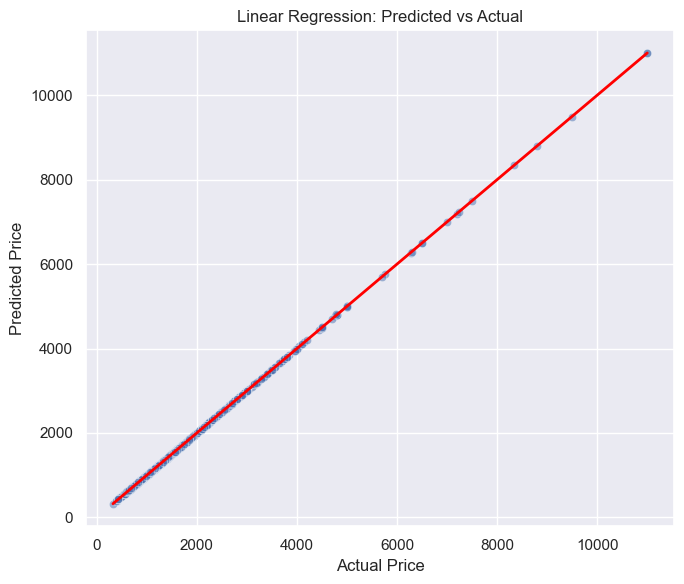

In [14]:
plt.figure(figsize=(7,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color="red", lw=2)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Linear Regression: Predicted vs Actual")
plt.tight_layout()
plt.show()

#### Residual plots

Checking if predictions are cetered around zero to know if it is does not either underpredict or overpredict

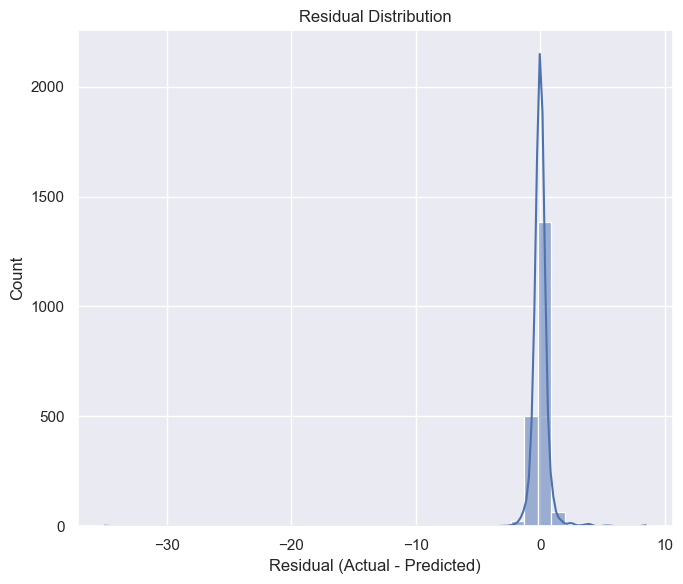

In [15]:
residuals = y_test - y_pred
plt.figure(figsize=(7,6))
sns.histplot(residuals, bins=40, kde=True)
plt.xlabel("Residual (Actual - Predicted)")
plt.title("Residual Distribution")
plt.tight_layout()
plt.show()

Width of model is narrow and centered mostly around zero with little noise continuing down the X axis. THis means that the model does not underpredict and also does not overpredict

#### Residual Scatter vs Predicted 

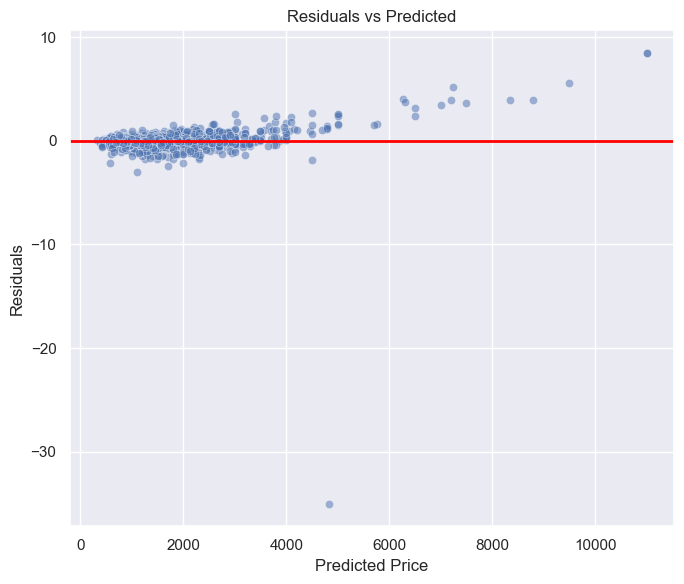

In [16]:
plt.figure(figsize=(7,6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.5)
plt.axhline(0, color="red", lw=2)
plt.xlabel("Predicted Price")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.tight_layout()
plt.show()

From the graph, since most points are tightly clustered around 0, the predictions are usually close to the actual pricing. There are a few dots below the line thus telling us that the model does occasionally overpredict expensive apartments. Towards the right side of the graph, the spreads widens, informing us that the model can't capture price variation well when it comes to more expensive, luxury listings.

#### Actual Price from data and Predicted Price from the model

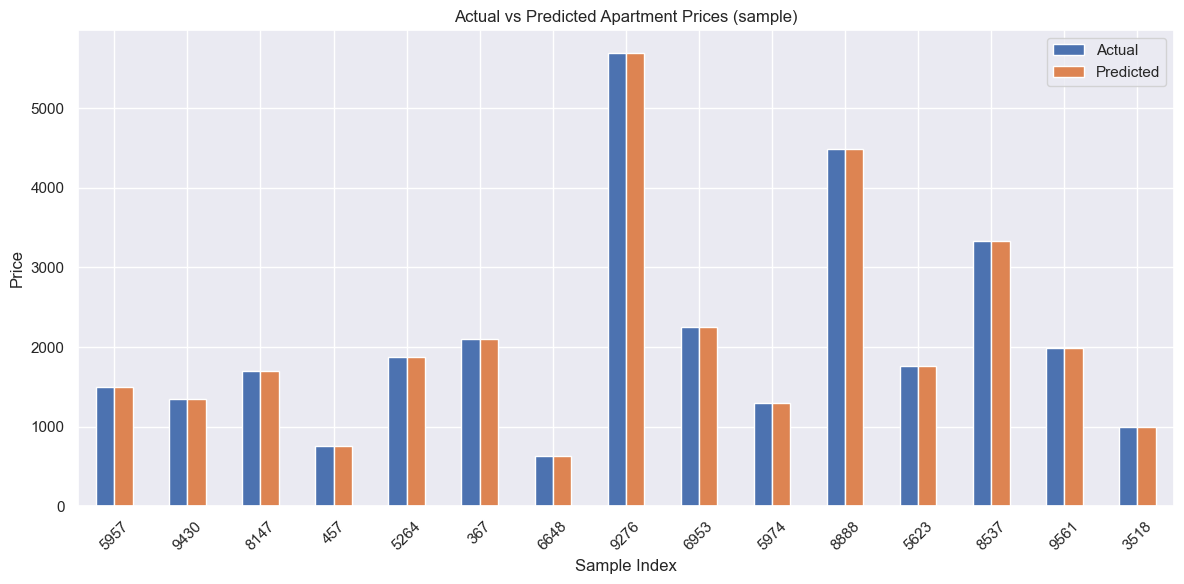

In [17]:
sample_idx = np.random.choice(len(y_test), size=15, replace=False)
sample_actual = y_test.iloc[sample_idx]
sample_pred   = y_pred[sample_idx]

plot_df = pd.DataFrame({
    "Actual": sample_actual.values,
    "Predicted": sample_pred
}, 
index=sample_actual.index)

plot_df.plot(kind="bar", figsize=(12,6))
plt.title("Actual vs Predicted Apartment Prices (sample)")
plt.ylabel("Price")
plt.xlabel("Sample Index")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Descision tree regressor

In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [19]:
#load the dataset
CSV_PATH = 'apartments_for_rent_classified_10K.csv'
df = pd.read_csv(CSV_PATH, sep=None, engine="python", encoding="cp1252")

df.columns = (
    df.columns                # Get the current column names
      .str.strip()            # Remove leading/trailing spaces
      .str.lower()            # Convert all letters to lowercase
      .str.replace(r"\s+", "_", regex=True)  # Replace spaces/tabs with underscores
)

#drop columns that are not needed for prediction
cols_to_drop = ['price_display']
df = df.drop(columns=cols_to_drop)

#display first few rows
df.head()

,id,category,title,body,amenities,bathrooms,bedrooms,currency,fee,has_photo,pets_allowed,price,price_type,square_feet,address,cityname,state,latitude,longitude,source,time
0,5668626895,housing/rent/apartment,"Studio apartment 2nd St NE, Uhland Terrace NE,...","This unit is located at second St NE, Uhland T...",NaN,NaN,0.0,USD,No,Thumbnail,NaN,790,Monthly,101,NaN,Washington,DC,38.9057,-76.9861,RentLingo,1577359415
1,5664597177,housing/rent/apartment,Studio apartment 814 Schutte Road,"This unit is located at 814 Schutte Road, Evan...",NaN,NaN,1.0,USD,No,Thumbnail,NaN,425,Monthly,106,814 Schutte Rd,Evansville,IN,37.9680,-87.6621,RentLingo,1577017063
2,5668626833,housing/rent/apartment,"Studio apartment N Scott St, 14th St N, Arling...","This unit is located at N Scott St, 14th St N,...",NaN,1.0,0.0,USD,No,Thumbnail,NaN,1390,Monthly,107,NaN,Arlington,VA,38.8910,-77.0816,RentLingo,1577359410
3,5659918074,housing/rent/apartment,Studio apartment 1717 12th Ave,"This unit is located at 1717 12th Ave, Seattle...",NaN,1.0,0.0,USD,No,Thumbnail,NaN,925,Monthly,116,1717 12th Avenue,Seattle,WA,47.6160,-122.3275,RentLingo,1576667743
4,5668626759,housing/rent/apartment,"Studio apartment Washington Blvd, N Cleveland ...","This unit is located at Washington Blvd, N Cle...",NaN,NaN,0.0,USD,No,Thumbnail,NaN,880,Monthly,125,NaN,Arlington,VA,38.8738,-77.1055,RentLingo,1577359401


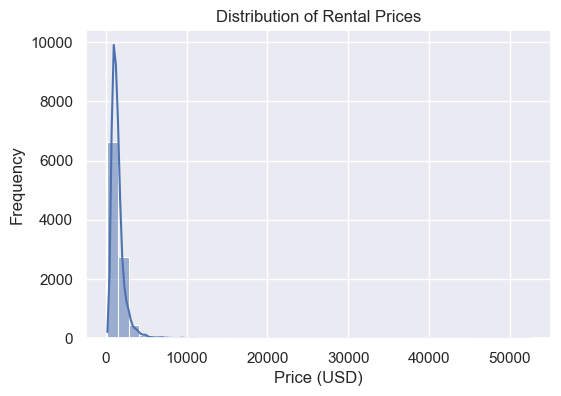

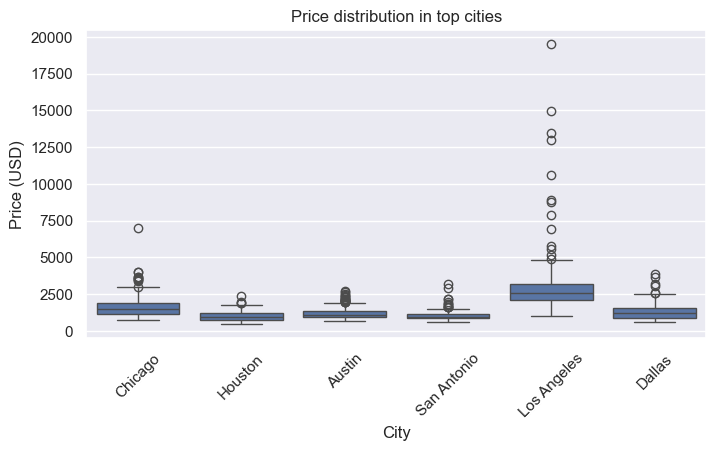

In [20]:
#visualise the distribution of the target variable
plt.figure(figsize=(6,4))
sns.histplot(df['price'], bins=40, kde=True)
plt.title('Distribution of Rental Prices')
plt.xlabel('Price (USD)')
plt.ylabel('Frequency')
plt.show()

#if city names are available, show price distribution across the most common cities
if 'cityname' in df.columns:
    top_cities = df['cityname'].value_counts().head(6).index
    plt.figure(figsize=(8,4))
    sns.boxplot(x='cityname', y='price', data=df[df['cityname'].isin(top_cities)])
    plt.title('Price distribution in top cities')
    plt.xlabel('City')
    plt.ylabel('Price (USD)')
    plt.xticks(rotation=45)
    plt.show()

In [21]:
#custom transformer to add a few engineered features
class AddCustomFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, add_features=True):
        self.add_features = add_features
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
        if not self.add_features:
            return X
        # Bedrooms-to-bathrooms ratio
        if {'bedrooms','bathrooms'}.issubset(X.columns):
            denom = X['bathrooms'].replace(0, np.nan) + 1e-6
            X['bed_bath_ratio'] = X['bedrooms'] / denom
        # Count of amenities if column exists
        if 'amenities' in X.columns:
            X['amenity_count'] = X['amenities'].fillna('').astype(str).str.count(',') + X['amenities'].notna().astype(int)
        # Length of title and body text
        if 'title' in X.columns:
            X['title_len'] = X['title'].fillna('').astype(str).str.len()
        if 'body' in X.columns:
            X['body_len'] = X['body'].fillna('').astype(str).str.len()
        # Log transform of square_feet to reduce skew
        if 'square_feet' in X.columns:
            X['log_square_feet'] = np.log1p(pd.to_numeric(X['square_feet'], errors='coerce'))
        return X

#preprocessor that dynamically separates numeric and categorical columns
class DynamicPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.preprocessor_ = None
    def fit(self, X, y=None):
        numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
        categorical_cols = [c for c in X.columns if c not in numeric_cols]
        num_tf = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])
        cat_tf = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ])
        self.preprocessor_ = ColumnTransformer([
            ('num', num_tf, numeric_cols),
            ('cat', cat_tf, categorical_cols)
        ])
        self.preprocessor_.fit(X, y)
        return self
    def transform(self, X):
        return self.preprocessor_.transform(X)


In [22]:
#for simplicity, drop a few identifier columns that have no predictive power
cols_to_drop = ['id','source']
drop_cols_exist = [c for c in cols_to_drop if c in df.columns]
use_cols = [c for c in df.columns if c not in drop_cols_exist]

X = df[use_cols].copy()
y = df['price'].copy()

#train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('Training set size:', X_train.shape)
print('Test set size:', X_test.shape)


Training set size: (8000, 19)
Test set size: (2000, 19)


In [23]:
#create a pipeline with the custom feature engineer,
#preprocessor and decision tree
pipe_dt = Pipeline([
    ('features', AddCustomFeatures()),
    ('prep', DynamicPreprocessor()),
    ('model', DecisionTreeRegressor(random_state=42))
])

#define a search space for the decision tree
search_space_dt = {
    'features__add_features': [True, False],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_leaf': [1, 2, 5],
    'model__min_samples_split': [2, 5, 10]
}

#perform randomized search with a limited number of iterations
rs_dt = RandomizedSearchCV(
    pipe_dt,
    param_distributions=search_space_dt,
    n_iter=10,
    cv=3,
    n_jobs=-1,
    scoring='neg_root_mean_squared_error',
    random_state=42,
    verbose=1
)

#fit the search to the training data
rs_dt.fit(X_train, y_train)

print('Best parameters:', rs_dt.best_params_)
print('Best CV RMSE:', -rs_dt.best_score_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters: {'model__min_samples_split': 5, 'model__min_samples_leaf': 2, 'model__max_depth': 20, 'features__add_features': False}
Best CV RMSE: 407.8155712152091


Decision Tree performance on test set:
MAE:  4.23
RMSE: 89.71
R^2:  0.9910


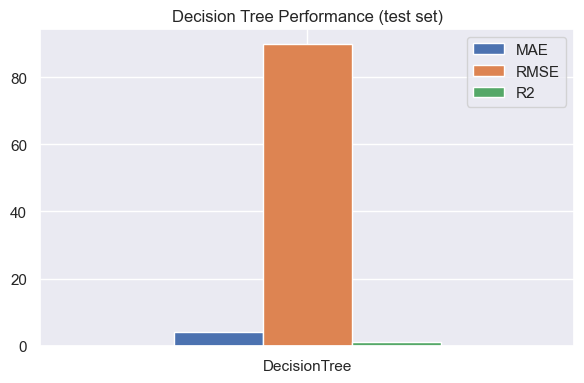

In [24]:
#retrieve the best estimator and make predictions on the test set
best_dt = rs_dt.best_estimator_
pred = best_dt.predict(X_test)

#compute evaluation metrics
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, pred)
r2 = r2_score(y_test, pred)

print('Decision Tree performance on test set:')
print(f'MAE:  {mae:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'R^2:  {r2:.4f}')

#put results in a DataFrame for nice display
results = pd.DataFrame({
    'MAE': [mae],
    'RMSE': [rmse],
    'R2': [r2]
}, index=['DecisionTree'])

import matplotlib.pyplot as plt
results.plot(kind='bar', figsize=(6,4))
plt.title('Decision Tree Performance (test set)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
